In [17]:
from astroquery.gaia import Gaia

job = Gaia.launch_job_async("""
SELECT
    source_id, ra, dec,
    parallax, pmra, pmdec,
    phot_g_mean_mag, bp_rp, ruwe
FROM gaiadr3.gaia_source
WHERE
    CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', 0.5, 67.4, 0.8)
    ) = 1
    AND parallax > 0
    AND parallax_over_error > 5
    AND ruwe < 1.4
    AND phot_g_mean_mag < 19
""")

INFO: Query finished. [astroquery.utils.tap.core]


In [18]:
df = job.get_results().to_pandas()
print(len(df))
df.to_csv("berk59_gaia.csv", index=False)

df.head()

8991


,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp,ruwe
0,528397903597993088,1.540997,66.713714,0.816924,-2.108440,0.231081,18.203331,2.231247,0.944889
1,528398865671435520,1.434007,66.811399,0.978115,-1.310542,1.539849,18.884037,2.435341,1.031464
2,528428178822778496,0.678925,66.621264,0.789738,4.162190,0.874916,17.291618,2.225449,1.090429
3,528431202483286400,0.082171,66.632964,0.475760,-3.694285,-1.628156,16.475941,2.083102,0.990459
4,528431507422075392,0.157339,66.675286,1.433951,-6.268130,2.489856,17.416273,2.392006,1.006148


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

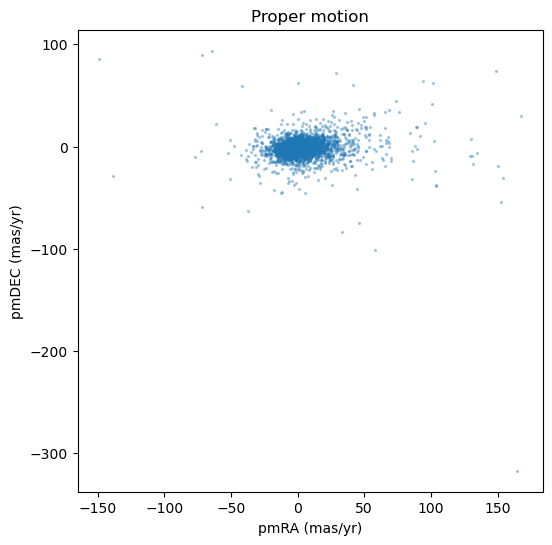

In [20]:
# phase space plot
# we will plot the data from the csv using matplotlib
# the y axis is the declination (north to south) and the x axis is the RIGHT ascension (west to east)
# they are the angle covered by a star in the celestial sphere per unit time; known as proper motion
# the cluster stars move together (share common motion), hence close in th plot, forming a lump or a cluster

plt.figure(figsize=(6,6))
plt.scatter(df.pmra, df.pmdec, s=2, alpha=0.3)
plt.xlabel('pmRA (mas/yr)') # milliarcseconds per year
plt.ylabel('pmDEC (mas/yr)')
plt.title('Proper motion')
plt.show()

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [22]:
X = df[['parallax', 'pmra', 'pmdec']].values 
# scaling done because they have different units, in order to ensure fair weighting of both
X_scaled = StandardScaler().fit_transform(X)

In [26]:
db = DBSCAN(eps=0.5, min_samples=10)

In [38]:
labels = db.fit_predict(X_scaled)

import numpy as np
np.unique(labels) 
# we have given label -1 to those stars outside the cluster using DBSCAN which finds overdensities in the plot

array([-1,  0])

In [35]:
df['cluster'] = labels

In [41]:
main_cluster = df['cluster'].value_counts().idxmax() 
members = df[df.cluster == main_cluster] # choose those IDs with label 0
members.head()

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp,ruwe,cluster
0,528397903597993088,1.540997,66.713714,0.816924,-2.108440,0.231081,18.203331,2.231247,0.944889,0
1,528398865671435520,1.434007,66.811399,0.978115,-1.310542,1.539849,18.884037,2.435341,1.031464,0
2,528428178822778496,0.678925,66.621264,0.789738,4.162190,0.874916,17.291618,2.225449,1.090429,0
3,528431202483286400,0.082171,66.632964,0.475760,-3.694285,-1.628156,16.475941,2.083102,0.990459,0
4,528431507422075392,0.157339,66.675286,1.433951,-6.268130,2.489856,17.416273,2.392006,1.006148,0


In [12]:
print('Cluster members:', len(members))

Cluster members: 8476


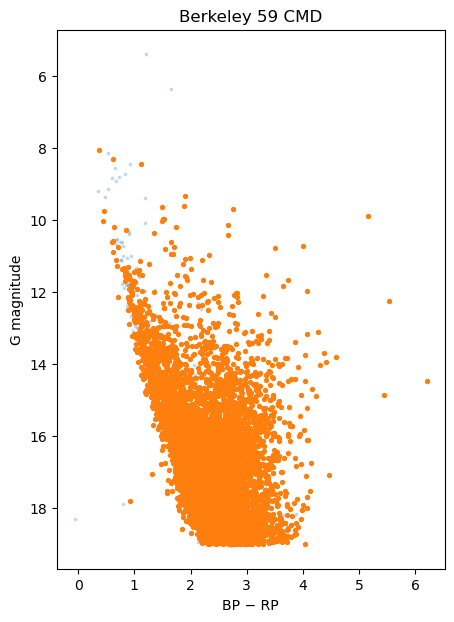

In [43]:
# cmd diagram 

plt.figure(figsize=(5,7))
plt.scatter(df.bp_rp, df.phot_g_mean_mag, s=3, alpha=0.2)
plt.scatter(members.bp_rp, members.phot_g_mean_mag, s=8)
plt.gca().invert_yaxis()
plt.xlabel('BP − RP') # color index (blue - red)
plt.ylabel('G magnitude') # analogous to apparent magnitude
plt.title('Berkeley 59 CMD')
plt.show()

# we can see **most** of the stars in berkeley 59 belong to the main sequence with a few exceptions

In [49]:
from astropy.io import fits
bands = ['g','r','i'] # different wavelength bands
images = {}
for b in bands:
    images[b] = fits.open(f'Berk_{b}.wcs.proc.fits')[0].data # importing the fits files (telescope images)

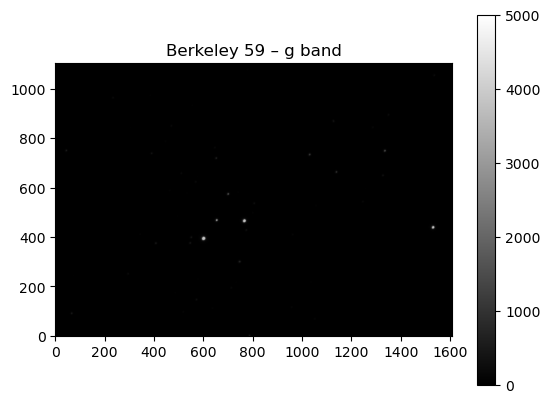

In [47]:
plt.imshow(images['g'], origin='lower', cmap='gray', vmin=0, vmax=5000)

plt.title('Berkeley 59 – g band')
plt.colorbar()
plt.show()

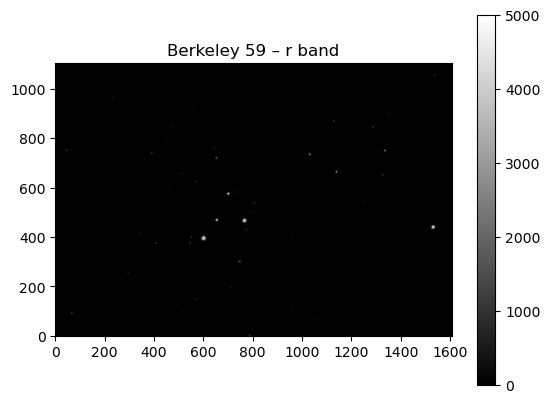

In [48]:
plt.imshow(images['r'], origin='lower', cmap='gray', vmin=0, vmax=5000)

plt.title('Berkeley 59 – r band')
plt.colorbar()
plt.show()

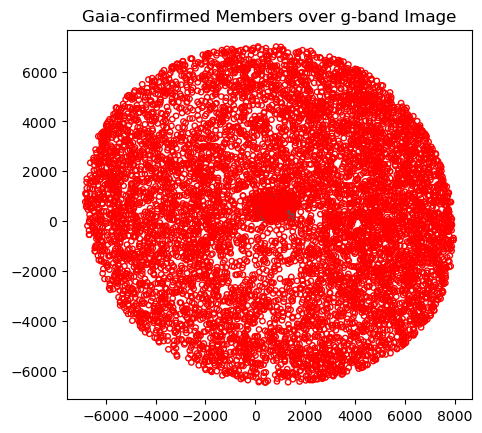

In [22]:
from astropy.wcs import WCS
hdr = fits.open('Berk_g.wcs.proc.fits')[0].header
wcs = WCS(hdr)
xpix, ypix = wcs.world_to_pixel_values(members.ra, members.dec)
plt.imshow(images['g'], origin='lower', cmap='gray')
plt.scatter(xpix, ypix, s=15, edgecolor='red', facecolor='none')
plt.title('Gaia-confirmed Members over g-band Image')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/astropy/wcs/wcsapi/fitswcs.py:346: UserWarning: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 20 iterations, the solution is diverging at least for one input point.
  warnings.warn(str(e))


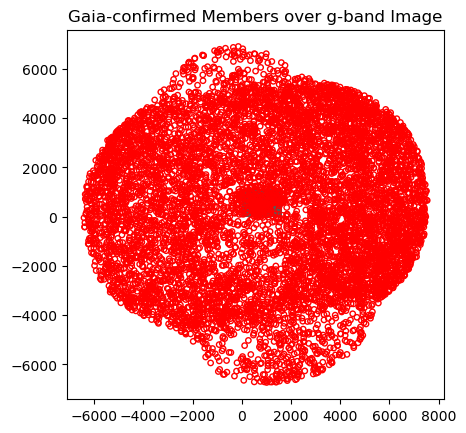

In [50]:
from astropy.wcs import WCS
hdr = fits.open('Berk_i.wcs.proc.fits')[0].header
wcs = WCS(hdr)
xpix, ypix = wcs.world_to_pixel_values(members.ra, members.dec)
plt.imshow(images['i'], origin='lower', cmap='gray')
plt.scatter(xpix, ypix, s=15, edgecolor='red', facecolor='none')
plt.title('Gaia-confirmed Members over g-band Image')
plt.show()